# Rare Variants

In [2]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variants'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [5]:
log_tpm = np.log10(tpm + 1)

## SNVs and indels

Get variants in promoters.

In [6]:
promoter_bt = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_merged.bed')
df = promoter_bt.to_dataframe()
s = '\n'.join(df.chrom.apply(lambda x: x[3:]) + '\t' + 
              df.start.astype(str) + '\t' + df.end.astype(str)) + '\n'
promoter_bt = pbt.BedTool(s, from_string=True)

In [7]:
vcfs = ['CARDIPS_chr{}_phased.vcf.gz'.format(x) for x in range(1, 23)]
vcfs = [os.path.join('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/', x) for x in vcfs]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_promoter_variants.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        c = 'bcftools view -Oz -R {} {} > {}'.format(promoter_bt.fn, vcf, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)

Annotate variants with 1,000 genomes European allele frequency.

In [8]:
for i in range(1, 23):
    vcf = os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants.vcf.gz'.format(i))
    kgp_vcf = ('/publicdata/1KGP_20151103/ALL.chr{}.'
               'phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'.format(i))
    out = os.path.split(vcf)[1].split('.')[0] + '_annot.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        c = ('bcftools annotate -a {} -c EUR_AF -Oz {} > {}'.format(kgp_vcf, vcf, out))
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)

Get merged roadmap DHSs for stem cell.

In [9]:
out = os.path.join(outdir, 'roadmap_stem_cell_dhs.bed')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    dhs_bt = pbt.BedTool(''.join([cpb.general.read_gzipped_text_url(url) for url in urls]), from_string=True)
    dhs_bt = dhs_bt.sort().merge()
    df = dhs_bt.to_dataframe()
    df.chrom = df.chrom.apply(lambda x: x[3:])
    s = '\n'.join(df.chrom + '\t' + df.start.astype(str) + 
                  '\t' + df.end.astype(str)) + '\n'
    dhs_bt = pbt.BedTool(s, from_string=True)
    dhs_bt.saveas(out)
else:
    dhs_bt = pbt.BedTool(out)

Get promoter DHS variants.

In [10]:
vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot.vcf.gz'.format(x)) 
        for x in range(1, 23)]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_dhs.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        temp = os.path.join(private_outdir, 'temp.vcf')
        c = 'bcftools view -m2 -M2 -Ov -R {} {} > {}'.format(dhs_bt.fn, vcf, temp)
        subprocess.check_call(c, shell=True)
        temp_header = os.path.join(private_outdir, 'temp_header.vcf')
        c = 'grep ^\\# {} > {}'.format(temp, temp_header)
        subprocess.check_call(c, shell=True)
        temp_lines = os.path.join(private_outdir, 'temp_lines.vcf')
        c = 'grep -v ^\\# {} | sort -k1,1 -k2,2n | uniq > {}'.format(temp, temp_lines)
        subprocess.check_call(c, shell=True)
        c = 'cat {} {} | bgzip > {}'.format(temp_header, temp_lines, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)
        c = 'rm {} {} {}'.format(temp, temp_header, temp_lines)
        subprocess.check_call(c, shell=True)

Filter promoter variants to only keep rare variants.

In [11]:
unrelateds = list(rna_meta_eqtl.ix[rna_meta_eqtl.in_unrelateds, 'wgs_id'])

In [12]:
vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs.vcf.gz'.format(x)) 
        for x in range(1, 23)]

for vcf in vcfs:
    vcf_reader = pyvcf.Reader(open(vcf))
    out = vcf.split('.')[0] + '_rare.vcf.gz'
    if not os.path.exists(out):
        f = open(out[:-3], 'w')
        vcf_writer = pyvcf.Writer(f, vcf_reader)
        eur_af = []
        unr_af = []
        unr_num_called = []
        for r in vcf_reader:
            if 'EUR_AF' in r.INFO.keys():
                eaf = r.INFO['EUR_AF'][0]
            else:
                eaf = 0
            eaf

            s = [x.sample for x in r.samples if x.called]
            gt = [x.gt_alleles for x in r.samples if x.called]
            gt = pd.DataFrame(gt, index=s, columns=['allele_a', 'allele_b'])
            gt = gt.ix[unrelateds].dropna()
            unr_num_called = gt.shape[0]

            se = pd.Series(0, index=['0', '1'])
            vc = gt.allele_a.value_counts()
            se.ix[vc.index] += vc
            vc = gt.allele_b.value_counts()
            se.ix[vc.index] += vc
            uaf = float(se.min()) / se.sum()
            if eaf < 0.005 and uaf < 0.1 and unr_num_called >= 100:
                vcf_writer.write_record(r)
        vcf_writer.close()
        f.close()
        !bgzip {out[:-3]}
        !bcftools index {out}

In [13]:
out = os.path.join(private_outdir, 'all_rare_variants.tsv')
if not os.path.exists(out):
    all_rare_vars = []
    vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs_rare.vcf.gz'.format(x)) 
            for x in range(1, 23)]
    for vcf in vcfs:
        temp = os.path.join(private_outdir, 'temp.vcf')
        !gunzip -c {vcf} > {temp}
        vcf_bt = pbt.BedTool(temp)
        t = vcf_bt.to_dataframe(names=range(len(vcf_bt[0].fields)))
        t = t[t[0].apply(lambda x: str(x)[0] != '#')][range(5)]
        t.columns = ['chrom', 'position', 'vid', 'ref', 'alt']
        t.chrom = 'chr' + t.chrom.astype(str)
        t.index = t.chrom + ':' + t.position.astype(str)
        all_rare_vars.append(t)
        !rm {temp}
    all_rare_vars = pd.concat(all_rare_vars)
    all_rare_vars['position'] = all_rare_vars['position'].astype(int)
    all_rare_vars['location'] = (all_rare_vars.chrom + ':' + (all_rare_vars.position - 1).astype(str) + '-' + 
                                 (all_rare_vars.position - 1 + all_rare_vars.ref.apply(lambda x: len(x))).astype(str))
    all_rare_vars.to_csv(out, sep='\t')
else:
    all_rare_vars = pd.read_table(out, index_col=0)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (0,1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [16]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
s = '\n'.join(df.chrom.apply(lambda x: x[3:]) + '\t' + 
              df.start.astype(str) + '\t' + df.end.astype(str) + 
              '\t' + df.name) + '\n'
promoters = pbt.BedTool(s, from_string=True)

In [ ]:
outa = os.path.join(private_outdir, 'rare_promoter_vars.tsv')
outb = os.path.join(private_outdir, 'rare_genotypes.tsv')
if not os.path.exists(outa) or not os.path.exists(outb):
    rare_promoter_vars = []
    rare_genotypes = []
    vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs_rare.vcf.gz'.format(x)) 
            for x in range(1, 23)]
    for vcf in vcfs:
        temp = os.path.join(private_outdir, 'temp.vcf')
        !gunzip -c {vcf} > {temp}
        vcf_bt = pbt.BedTool(temp)

        res = vcf_bt.intersect(promoters, sorted=True, wo=True)
        df = res.to_dataframe(names=range(len(res[0].fields)))

        se = df[304].apply(lambda x: x.split('_')[0])
        se.index = df[0].astype(str) + ':' + df[1].astype(str)
        rare_promoter_vars.append(se)

        genotypes = pd.DataFrame(np.nan, index=set(se.index), columns=list(set(rna_meta.wgs_id)))
        gcols = set(genotypes.columns)
        vcf_reader = pyvcf.Reader(open(vcf))

        for r in vcf_reader:
            key = r.CHROM + ':' + str(r.POS)
            if key in genotypes.index:
                s = set([x.sample for x in r.get_hom_refs()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 0
                s = set([x.sample for x in r.get_hets()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 1
                s = set([x.sample for x in r.get_hom_alts()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 2
        rare_genotypes.append(genotypes)
        !rm {temp}
    rare_genotypes = pd.concat(rare_genotypes)
    rare_promoter_vars = pd.concat(rare_promoter_vars)
    rare_promoter_vars.to_csv(outa, sep='\t')
    rare_genotypes.to_csv(outb, sep='\t')
else:
    rare_promoter_vars = pd.read_table(outa, index_col=0)
    rare_genotypes = pd.read_table(outb, index_col=0)

In [ ]:
gene_info.ix[set(rare_promoter_vars), 'gene_type'].value_counts().head()

In [ ]:
rare_genotypes_f = rare_genotypes[rare_genotypes[unrelateds].sum(axis=1) > 0]
rare_genotypes_f = rare_genotypes_f[unrelateds]

In [ ]:
log_tpm_f = log_tpm[rna_meta[rna_meta.in_unrelateds].index]
log_tpm_f.columns = rna_meta.ix[rna_meta.in_unrelateds, 'wgs_id']
log_tpm_f = log_tpm_f[(log_tpm_f > np.log10(2)).sum(axis=1) >= 10]

In [ ]:
log_tpm_c = (log_tpm_f.T - log_tpm_f.mean(axis=1)).T
log_tpm_z = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

In [ ]:
rare_promoter_vars_f = rare_promoter_vars[rare_promoter_vars.apply(lambda x: x in log_tpm_f.index)]
rare_promoter_vars_f = pd.DataFrame({'variant':rare_promoter_vars_f.index, 'gene':rare_promoter_vars_f.values})
rare_promoter_vars_f = rare_promoter_vars_f[rare_promoter_vars_f.variant.apply(lambda x: x in rare_genotypes_f.index)]

In [ ]:
ase_pval_f = ase_pval[rna_meta[rna_meta.in_unrelateds].index]
ase_pval_f.columns = rna_meta[rna_meta.in_unrelateds].wgs_id

In [ ]:
rare = []
rare_ase_pval = []
not_rare = []
not_rare_ase_pval = []
for i in rare_promoter_vars_f.index:
    v = rare_promoter_vars_f.ix[i, 'variant']
    g = rare_promoter_vars_f.ix[i, 'gene']
    se = rare_genotypes_f.ix[v]
    r = se[se != 0].index
    nr = se[se == 0].index
    rare += list(log_tpm_z.ix[g, r])
    not_rare += list(log_tpm_z.ix[g, nr])
    if g in ase_pval.index:
        rare_ase_pval += list(ase_pval_f.ix[g, r])
        not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
rare = pd.Series(rare)
not_rare = pd.Series(not_rare)
rare_ase_pval = pd.Series(rare_ase_pval).dropna()
not_rare_ase_pval = pd.Series(not_rare_ase_pval).dropna()

In [ ]:
print(sum(rare_ase_pval < 0.005) / float(rare_ase_pval.shape[0]))
print(sum(not_rare_ase_pval < 0.005) / float(not_rare_ase_pval.shape[0]))

0.0333493542536
0.0285496386439


In [ ]:
a = (rare_ase_pval < 0.005).value_counts()
b = (not_rare_ase_pval < 0.005).value_counts()
stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])

(1.1739183251397136, 1.4049781140121933e-12)

Gene/sample pairs with a rare DHS promoter variant are enriched for ASE.

In [ ]:
stats.mannwhitneyu(rare, not_rare)

MannwhitneyuResult(statistic=800279716348.5, pvalue=1.7518097104229338e-140)

In [ ]:
stats.mannwhitneyu(rare.abs(), not_rare.abs())

MannwhitneyuResult(statistic=811195463263.5, pvalue=4.3047967112631712e-61)

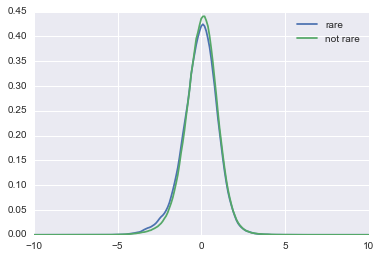

In [ ]:
xs = np.arange(-10, 10.1, 0.1)
density = scipy.stats.gaussian_kde(rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

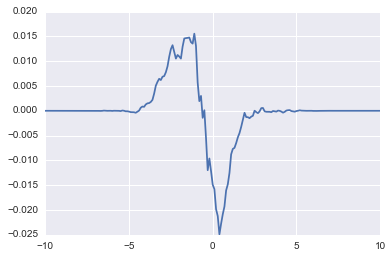

In [ ]:
(y_rare - y_not_rare).plot()

In [ ]:
rare.abs().median()

0.641515715315933

In [ ]:
not_rare.abs().median()

0.6182334114999083

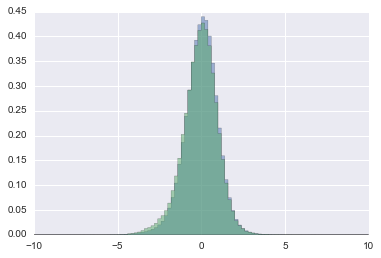

In [ ]:
not_rare.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), alpha=0.5, histtype='stepfilled')
rare.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), alpha=0.5, histtype='stepfilled')

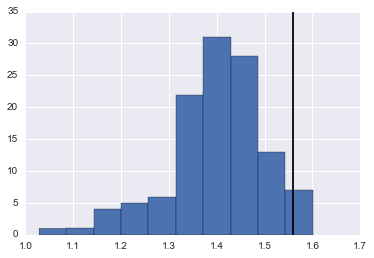

In [ ]:
v = rare_genotypes_f.index[0]
g = rare_promoter_vars[v]
if type(g) == pd.Series:
    g = g.values[0]
if g in log_tpm_f.index:
    se = rare_genotypes_f.ix[v]
    log_tpm_f.ix[g].hist()
    ymin,ymax = plt.ylim()
    plt.vlines(log_tpm_f.ix[g, se[se != 0].index], ymin, ymax)

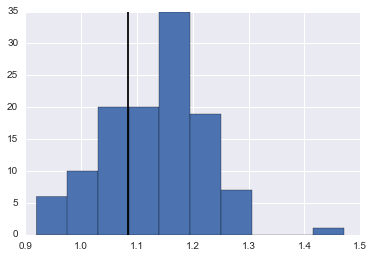

In [ ]:
v = rare_genotypes_f.index[2]
g = rare_promoter_vars[v]
if type(g) == pd.Series:
    g = g.values[0]
if g in log_tpm_f.index:
    se = rare_genotypes_f.ix[v]
    log_tpm_f.ix[g].hist()
    ymin,ymax = plt.ylim()
    plt.vlines(log_tpm_f.ix[g, se[se != 0].index], ymin, ymax)

### TF motif disruptions

We can see that promoter variants in DHS disrupt expression. Is the signal stronger
if we also require the variants to disrupt TF motifs?

In [ ]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in set(motif_info_rep.tf))]

In [ ]:
out = os.path.join(private_outdir, 'tf_overlap.tsv')
if not os.path.exists(out):
    s = '\n'.join(all_rare_vars.chrom + '\t' + (all_rare_vars.position - 1).astype(str) + 
                  '\t' + all_rare_vars.position.astype(str) + '\t' + 
                  pd.Series(all_rare_vars.index, index=all_rare_vars.index)) + '\n'
    rv_bt = pbt.BedTool(s, from_string=True).sort()
    tf_overlap = pd.DataFrame(False, index=all_rare_vars.index, columns=encode_tf_chip_seq.target)

    for i in encode_tf_chip_seq.index:
        target = encode_tf_chip_seq.ix[i, 'target']
        s = cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url'])
        bt = pbt.BedTool(s, from_string=True)
        bt = bt.sort()
        res = rv_bt.intersect(bt, sorted=True, wo=True)
        df = res.to_dataframe(names=range(len(res[0].fields)))
        tf_overlap.ix[set(df[3]), target] = True
    tf_overlap.to_csv(out, sep='\t')
else:
    tf_overlap = pd.read_table(out, index_col=0)

In [51]:
out = os.path.join(outdir, 'tf_disruption.tsv')
if not os.path.exists(out):
    tdf = tf_overlap[tf_overlap.sum(axis=1) > 0]
    var_tf_overlaps = {}
    for i in tdf.index:
        se = tdf.ix[i]
        se = se[se]
        var_tf_overlaps[i] = list(motif_info[motif_info.tf.apply(lambda x: x in se.index)].index)
    tf_disruption = pd.DataFrame(False, index=tf_overlap.index, columns=tf_overlap.columns)

    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(all_rare_vars=all_rare_vars));
    dview.push(dict(var_tf_overlaps=var_tf_overlaps));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            all_rare_vars.ix[i, 'location'], all_rare_vars.ix[i, 'ref'], all_rare_vars.ix[i, 'alt'], 
            cpy.hg19, {k:matrices[k] for k in matrices.keys() if k in var_tf_overlaps[i]}), 
                         var_tf_overlaps.keys())
#     cols = motif_info[motif_info.tf.apply(lambda x: x in [x.split('_')[0] for x in tf_cols])].index
#     motif_d = pd.DataFrame(index=tdf.index, columns=cols)
#     a = []
#     b = []
#     for i,p in enumerate(tdf.index):
#         if res[i].shape[0] > 0:
#             a.append(p)
#             b.append(res[i])
#     d = dict(zip(a,b))
#     p = pd.Panel(d)
#     motif_d = p.ix[:, :, 'score_diff'].T
#     motif_d.to_csv(out, sep='\t')
# else:
#     motif_d = pd.read_table(out, index_col=0)

In [68]:
for i,k in enumerate(var_tf_overlaps.keys()):
    if res[i].shape[0] > 0:
        tf_disruption.ix[k, set(motif_info.ix[res[i].index, 'tf'])] = True

In [88]:
t = pd.DataFrame({'variant':tf_disruption[tf_disruption.sum(axis=1) > 0].index,
                  'tf_disrupt':True})
t['variant'] = t.variant.apply(lambda x: x[3:])
rare_promoter_vars_f_tf = rare_promoter_vars_f.merge(t)

In [ ]:
tf_rare = []
tf_rare_ase_pval = []
not_tf_rare = []
not_tf_rare_ase_pval = []
for i in rare_promoter_vars_f_tf.index:
    v = rare_promoter_vars_f_tf.ix[i, 'variant']
    g = rare_promoter_vars_f_tf.ix[i, 'gene']
    se = rare_genotypes_f.ix[v]
    r = se[se != 0].index
    nr = se[se == 0].index
    tf_rare += list(log_tpm_z.ix[g, r])
    not_tf_rare += list(log_tpm_z.ix[g, nr])
    if g in ase_pval.index:
        tf_rare_ase_pval += list(ase_pval_f.ix[g, r])
        not_tf_rare_ase_pval += list(ase_pval_f.ix[g, nr])
tf_rare = pd.Series(tf_rare)
not_tf_rare = pd.Series(not_tf_rare)
tf_rare_ase_pval = pd.Series(tf_rare_ase_pval).dropna()
not_tf_rare_ase_pval = pd.Series(not_tf_rare_ase_pval).dropna()

In [92]:
print(sum(tf_rare_ase_pval < 0.005) / float(tf_rare_ase_pval.shape[0]))
print(sum(not_tf_rare_ase_pval < 0.005) / float(not_tf_rare_ase_pval.shape[0]))

0.0348662458671
0.0286699073059


In [93]:
a = (tf_rare_ase_pval < 0.005).value_counts()
b = (not_tf_rare_ase_pval < 0.005).value_counts()
stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])

(1.2239346743867523, 4.6208145428937965e-07)

In [121]:
stats.mannwhitneyu(tf_rare, not_tf_rare)

MannwhitneyuResult(statistic=69544518522.5, pvalue=6.7625121638185906e-41)

In [122]:
stats.mannwhitneyu(tf_rare.abs(), not_tf_rare.abs())

MannwhitneyuResult(statistic=70019304284.5, pvalue=3.5321294647439391e-28)

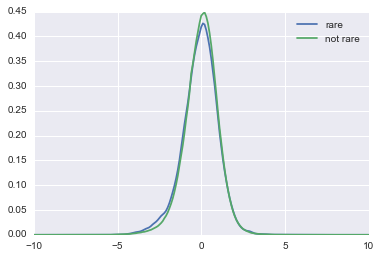

In [94]:
xs = np.arange(-10, 10.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_tf_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

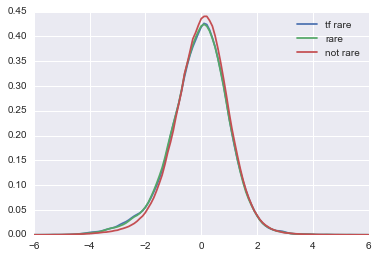

In [115]:
xs = np.arange(-6, 6.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_tf_rare = density(xs)
density = scipy.stats.gaussian_kde(rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_rare)
y_not_rare = density(xs)
y_tf_rare = pd.Series(y_tf_rare, index=xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_tf_rare.plot(label='tf rare')
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

## Rare CNVs

In [98]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/cnv_genotypes.tsv')
cnv_geno = pd.read_table(fn, index_col=0)

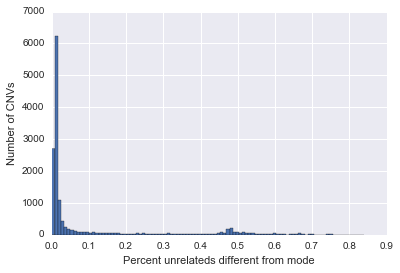

In [99]:
cnv_info.unrelated_percent_diff_from_mode.hist(bins=100)
plt.ylabel('Number of CNVs')
plt.xlabel('Percent unrelateds different from mode');

In [100]:
cnv_info.sort_values(by='unrelated_diff_from_mode', inplace=True)

In [101]:
rare_cnv_info = cnv_info[cnv_info.unrelated_diff_from_mode == 1]
rare_cnv_info = rare_cnv_info.dropna(subset=['gene_overlaps'])

In [102]:
cnv_rare = []
cnv_rare_ase_pval = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
cnv_not_rare_ase_pval = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        cnv_rare += list(log_tpm_z.ix[g, r])
        cnv_rare_less += list(log_tpm_z.ix[g, lessr])
        cnv_rare_greater += list(log_tpm_z.ix[g, greaterr])
        cnv_not_rare += list(log_tpm_z.ix[g, nr])
        if g in ase_pval.index:
            cnv_rare_ase_pval += list(ase_pval_f.ix[g, r])
            cnv_not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
cnv_rare = pd.Series(cnv_rare)
cnv_rare_ase_pval = pd.Series(cnv_rare_ase_pval).dropna()
cnv_not_rare = pd.Series(cnv_not_rare)
cnv_rare_less = pd.Series(cnv_rare_less)
cnv_rare_greater = pd.Series(cnv_rare_greater)
cnv_not_rare_ase_pval = pd.Series(cnv_not_rare_ase_pval).dropna()

In [103]:
print(sum(cnv_rare_ase_pval < 0.005) / float(cnv_rare_ase_pval.shape[0]))
print(sum(cnv_not_rare_ase_pval < 0.005) / float(cnv_not_rare_ase_pval.shape[0]))

0.0803964757709
0.0311648535232


In [104]:
print(stats.mannwhitneyu(cnv_rare, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=291432300.5, pvalue=8.4124214474838929e-08)
MannwhitneyuResult(statistic=278378118.5, pvalue=1.5618313819213933e-18)


In [105]:
print(stats.mannwhitneyu(cnv_rare_less, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_less.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=244274758.0, pvalue=0.26920546044906934)
MannwhitneyuResult(statistic=195411157.0, pvalue=8.539737391520741e-53)


In [106]:
print(stats.mannwhitneyu(cnv_rare_greater, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_greater.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=48318389.0, pvalue=3.2154123707138734e-22)
MannwhitneyuResult(statistic=52732573.0, pvalue=9.762408868882238e-13)


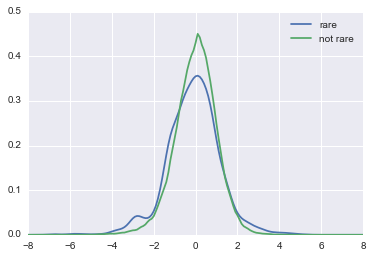

In [107]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

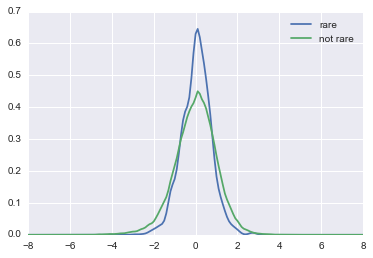

In [108]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_less)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

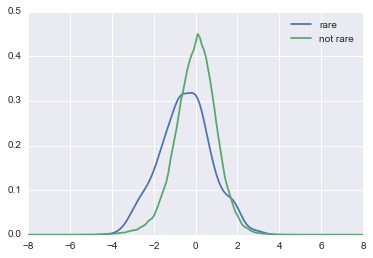

In [109]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_greater)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

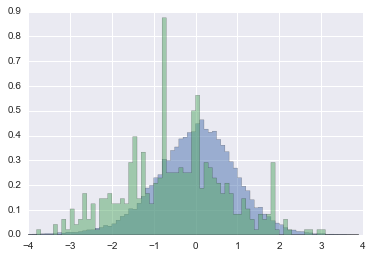

In [110]:
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled')
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled')

In [111]:
cnv_rare = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        if greaterr.shape[0] > 0:
            if sum(log_tpm_z.ix[g, greaterr] < -2) > 0:
                print(i, g, greaterr)

('CNV_8_146276675_146279317', 'ENSG00000182307.8', f4b0146d-7508-457f-a754-bb4042583c4b    3
Name: CNV_8_146276675_146279317, dtype: int64)
('CNV_9_36273428_36278602', 'ENSG00000122705.12', 7e46a561-21f6-4340-b2e2-41ef50b7d943    3
Name: CNV_9_36273428_36278602, dtype: int64)
('CNV_7_148820780_148825437', 'ENSG00000197024.4', d5034b1e-43c1-486a-8d18-18b15f635e70    3
Name: CNV_7_148820780_148825437, dtype: int64)
('CNV_7_133582402_133604451', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133582402_133604451, dtype: int64)
('CNV_7_133552783_133574111', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133552783_133574111, dtype: int64)
('CNV_7_133526828_133552782', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133526828_133552782, dtype: int64)
('CNV_7_133472945_133511987', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133472945_133511987, dtype: int64)
('CNV_7_133425056_1

In [112]:
gene_info.ix['ENSG00000122705.12']

gene_name                CLTA
gene_type      protein_coding
chrom                    chr9
start                36190852
end                  36304778
strand                      +
gene_status             KNOWN
source                 HAVANA
level                       1
Name: ENSG00000122705.12, dtype: object

In [113]:
cnv_rare_greater.head()

AttributeError: 'list' object has no attribute 'head'

In [128]:
tt = log_tpm_z.apply(lambda x: stats.mstats.normaltest(x)[1], axis=1)

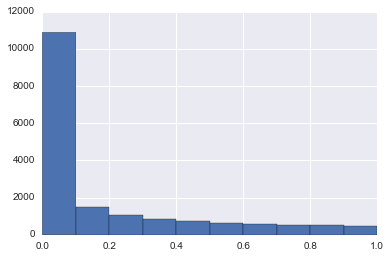

In [129]:
tt.hist()